In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

/Users/ericrosenbaum/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
2024-10-13 16:12:40.062741: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:

# Step 1: Data Collection (fetch stock data using Yahoo Finance)
def fetch_stock_data(ticker, period='1mo', interval='5m'):
    """
    Fetch historical stock data from Yahoo Finance.
    
    Args:
        ticker (str): The stock ticker symbol.
        period (str): The period of data to retrieve (e.g., '1mo', '3mo', '1y').
        interval (str): The data interval (e.g., '1m' for 1-minute data, '5m' for 5-minute data).
    
    Returns:
        pd.DataFrame: Historical stock data including open, close, high, low, and volume.
    """
    data = yf.download(ticker, period=period, interval=interval)
    return data

# Step 2: Add Technical Indicators
def add_technical_indicators(data):
    """
    Add technical indicators to the stock price data.
    
    Args:
        data (pd.DataFrame): Stock price data.
    
    Returns:
        pd.DataFrame: Stock price data with added technical indicators.
    """
    # Simple Moving Average (SMA)
    data['SMA_20'] = data['Close'].rolling(window=20).mean()
    
    # Exponential Moving Average (EMA)
    data['EMA_20'] = data['Close'].ewm(span=20, adjust=False).mean()
    
    # Relative Strength Index (RSI)
    data['RSI'] = compute_RSI(data['Close'])
    
    # Volatility (standard deviation of close price over last 20 periods)
    data['Volatility'] = data['Close'].rolling(window=20).std()
    
    # Bollinger Bands (upper and lower)
    data['Bollinger_High'] = data['SMA_20'] + 2 * data['Volatility']
    data['Bollinger_Low'] = data['SMA_20'] - 2 * data['Volatility']
    
    return data

# Helper Function to Compute RSI (Relative Strength Index)
def compute_RSI(data, window=14):
    """
    Compute the Relative Strength Index (RSI) for stock prices.
    
    Args:
        data (pd.Series): Stock price data (typically closing prices).
        window (int): The window length to calculate RSI.
    
    Returns:
        pd.Series: The RSI values for the stock prices.
    """
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Step 3: Data Preprocessing (scaling data for machine learning models)
def preprocess_data(data):
    """
    Scale the stock data for model input using MinMaxScaler.
    
    Args:
        data (pd.DataFrame): Stock price data with technical indicators.
    
    Returns:
        np.array: Scaled data.
        MinMaxScaler: The scaler used to transform the data (to inverse transform later).
    """
    # Selecting relevant features for the model
    features = ['Close', 'Volume', 'SMA_20', 'EMA_20', 'RSI', 'Volatility', 'Bollinger_High', 'Bollinger_Low']
    data = data[features].fillna(0)  # Fill any missing values
    
    # Initialize MinMaxScaler to scale all values between 0 and 1
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    # Fit and transform the data
    scaled_data = scaler.fit_transform(data)
    
    return scaled_data, scaler

# Example Usage
if __name__ == "__main__":
    # Fetch the stock data for Apple (AAPL) for 1 month with 5-minute intervals
    ticker = 'AAPL'
    stock_data = fetch_stock_data(ticker, period='1mo', interval='5m')
    
    # Add technical indicators to the data
    stock_data_with_indicators = add_technical_indicators(stock_data)
    
    # Preprocess (scale) the data
    scaled_data, scaler = preprocess_data(stock_data_with_indicators)
    
    # Print the first 5 rows of the processed data
    print(pd.DataFrame(scaled_data, columns=['Close', 'Volume', 'SMA_20', 'EMA_20', 'RSI', 'Volatility', 'Bollinger_High', 'Bollinger_Low']).head())


[*********************100%***********************]  1 of 1 completed

      Close    Volume  SMA_20    EMA_20  RSI  Volatility  Bollinger_High  \
0  0.390767  0.109976     0.0  0.368090  0.0         0.0             0.0   
1  0.350778  0.049584     0.0  0.363739  0.0         0.0             0.0   
2  0.358562  0.049336     0.0  0.360649  0.0         0.0             0.0   
3  0.302737  0.051044     0.0  0.351779  0.0         0.0             0.0   
4  0.347827  0.041194     0.0  0.348660  0.0         0.0             0.0   

   Bollinger_Low  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  


[*********************100%***********************]  1 of 1 completed
/Users/ericrosenbaum/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 0.1247 - val_loss: 0.0024
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0133 - val_loss: 0.0013
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0096 - val_loss: 0.0010
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0085 - val_loss: 8.7183e-04
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0076 - val_loss: 0.0015
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0071 - val_loss: 8.7193e-04
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0066 - val_loss: 9.2514e-04
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0060 - val_loss: 0.0045
Epoch 9/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0069 - val_loss: 0.0010
Epoch 10/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0051 - val_loss: 9.5271e-04
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step


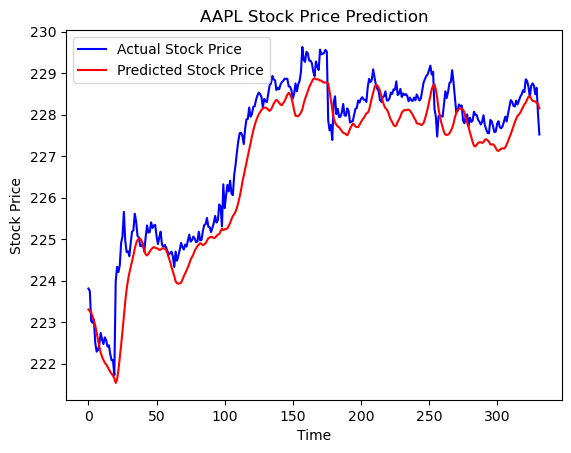

In [3]:

# Step 4: Create Sequences for Time-Series Data
def create_sequences(data, sequence_length=60):
    """
    Create sequences from the scaled data for training the LSTM model.
    
    Args:
        data (np.array): The scaled stock data.
        sequence_length (int): The length of each input sequence.
    
    Returns:
        np.array: Input sequences for the model.
        np.array: Corresponding target values (the stock price we want to predict).
    """
    X, y = [], []
    for i in range(sequence_length, len(data)):
        X.append(data[i-sequence_length:i])
        y.append(data[i, 0])  # We are predicting the 'Close' price (index 0)
    
    return np.array(X), np.array(y)

# Step 5: Build the LSTM Model
def build_lstm_model(input_shape):
    """
    Build and compile an LSTM model for stock price prediction.
    
    Args:
        input_shape (tuple): The shape of the input data (sequence length, number of features).
    
    Returns:
        keras.Model: Compiled LSTM model.
    """
    model = Sequential()
    
    # Adding the first LSTM layer with Dropout regularization
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    
    # Adding a second LSTM layer
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    
    # Adding a Dense output layer to predict the stock price
    model.add(Dense(units=25))
    model.add(Dense(units=1))  # Predicting one value (next stock price)
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

# Step 6: Train the Model
def train_model(model, X_train, y_train, epochs=10, batch_size=32):
    """
    Train the LSTM model with the given training data.
    
    Args:
        model (keras.Model): The compiled LSTM model.
        X_train (np.array): Training input sequences.
        y_train (np.array): Training target values (actual stock prices).
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.
    
    Returns:
        keras.History: History of model training (for analysis of loss, etc.).
    """
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
    return history

# Step 7: Make Predictions
def make_predictions(model, X_test, scaler):
    """
    Make predictions using the trained LSTM model and inverse scale the results.
    
    Args:
        model (keras.Model): The trained LSTM model.
        X_test (np.array): Test input sequences for prediction.
        scaler (MinMaxScaler): The scaler used for data normalization.
    
    Returns:
        np.array: The predicted stock prices (inverse scaled back to original values).
    """
    predictions_scaled = model.predict(X_test)
    
    # Inverse transform the predictions back to original scale
    zeros = np.zeros((predictions_scaled.shape[0], scaler.n_features_in_ - 1))  # Placeholder for other columns
    predictions = np.concatenate((predictions_scaled, zeros), axis=1)  # Add back the other features as zeros
    predictions = scaler.inverse_transform(predictions)[:, 0]  # Only return the 'Close' prices
    
    return predictions

# Example Usage
if __name__ == "__main__":
    # Fetch the stock data for Apple (AAPL) for 1 month with 5-minute intervals
    ticker = 'AAPL'
    stock_data = fetch_stock_data(ticker, period='1mo', interval='5m')
    
    # Add technical indicators to the data
    stock_data_with_indicators = add_technical_indicators(stock_data)
    
    # Preprocess (scale) the data
    scaled_data, scaler = preprocess_data(stock_data_with_indicators)
    
    # Create sequences for training (sequence length = 60)
    sequence_length = 60
    X, y = create_sequences(scaled_data, sequence_length)
    
    # Split data into training and testing sets
    train_size = int(0.8 * len(X))
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]
    
    # Build the LSTM model
    input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence length, number of features)
    model = build_lstm_model(input_shape)
    
    # Train the model
    history = train_model(model, X_train, y_train, epochs=10, batch_size=32)
    
    # Make predictions on the test set
    predictions = make_predictions(model, X_test, scaler)
    
    # Inverse scale the actual test values for comparison
    zeros_for_test = np.zeros((y_test.shape[0], scaler.n_features_in_ - 1))
    y_test_actual = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), zeros_for_test), axis=1))[:, 0]
    
    # Plot actual vs predicted prices
    plt.plot(y_test_actual, color='blue', label='Actual Stock Price')
    plt.plot(predictions, color='red', label='Predicted Stock Price')
    plt.title(f'{ticker} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()
    
